In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install pystan==2.19.1.1
# !pip install convertdate
# !pip install lunarcalendar
# !pip install holidays==0.10.5
!pip install prophet

In [3]:
from prophet import Prophet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

It has a wierd rule that the date column should be named as ds and target column should be named as y and ds column should be column not index

In [5]:
df=pd.read_excel("/content/drive/MyDrive/Prices.xlsx",
                 sheet_name="Daily",
                 usecols="A,B",
                 names=["ds","y"]
                 )

In [6]:
df.set_index('ds',inplace=True)

In [7]:
df = df.loc[(df.index.year > 2000), :]
df.index = pd.to_datetime(df.index)

In [8]:
df = df.resample('M').mean()

In [9]:
df.head()

,y
ds,
2001-01-31,265.876087
2001-02-28,261.865000
2001-03-31,263.027273
2001-04-30,260.361905
2001-05-31,272.273913


creating simple or base model using fb prophet

In [10]:
df.reset_index(inplace=True)

**Fitting base model**

In [11]:
prophet_model = Prophet()
prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpln8g6erx/neoa_hsy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpln8g6erx/mn7bgtw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96834', 'data', 'file=/tmp/tmpln8g6erx/neoa_hsy.json', 'init=/tmp/tmpln8g6erx/mn7bgtw8.json', 'output', 'file=/tmp/tmpln8g6erx/prophet_modelg4e80ada/prophet_model-20240722122829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:28:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:28:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


We now be creating future dataset for forecating

In [17]:
# we are only considering years for forecasting for now lets consider 24 months

future_dataset= prophet_model.make_future_dataframe(periods=48, freq='m') # Next 15 YEARS OF DATA
future_dataset.head()

,ds
0,2001-01-31
1,2001-02-28
2,2001-03-31
3,2001-04-30
4,2001-05-31


When it comes to prediction, the model predicts the value from scratch means from day 1 to the last row of the dataframe, its not just print the forecast of newer or test dataset

In [18]:
pred = prophet_model.predict(future_dataset)

In [19]:
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail() # only useful columns   because at starting some training data prediction would be there

,ds,yhat,yhat_lower,yhat_upper
325,2028-02-29,2616.748947,2393.470125,2836.159152
326,2028-03-31,2626.138038,2388.833435,2845.361097
327,2028-04-30,2635.445504,2416.536687,2851.545442
328,2028-05-31,2633.344542,2395.332311,2852.825271
329,2028-06-30,2636.146285,2397.853805,2862.801090


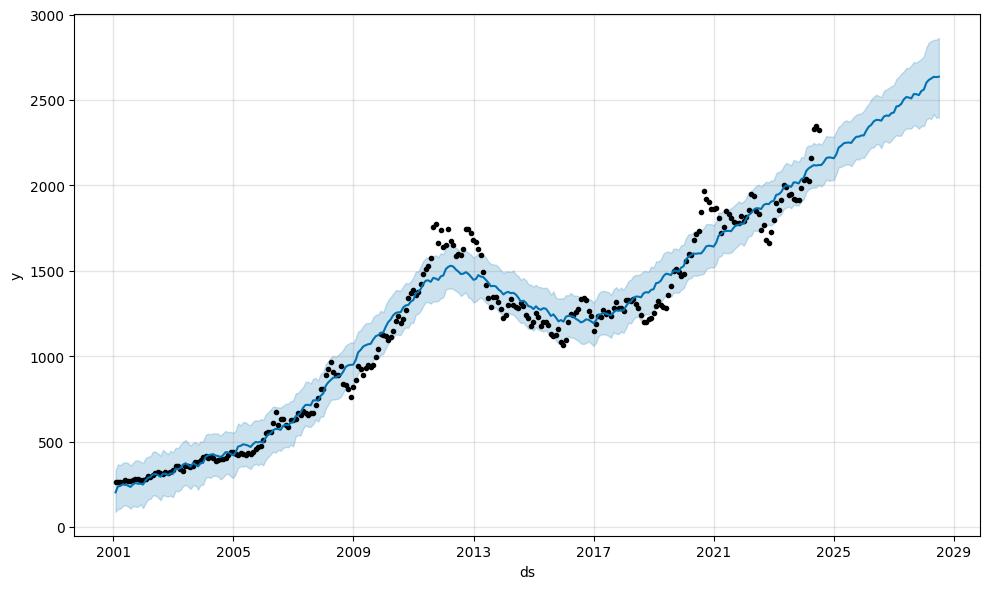

In [20]:
prophet_model.plot(pred);

In [21]:
df1=df.copy()
pred1=pred.copy()
pred1=pred1[['ds','yhat']]
df1=df1[['ds','y']]

In [22]:
pred1.set_index('ds',inplace=True)
df1.set_index('ds',inplace=True)

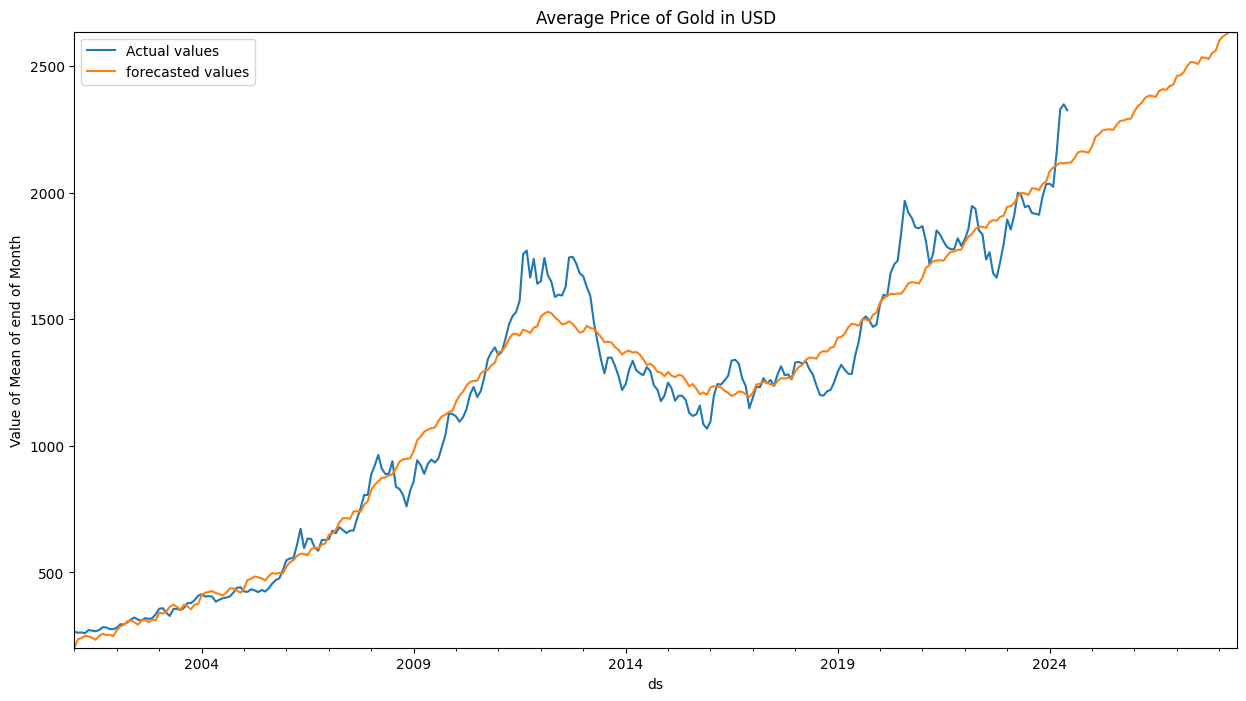

In [25]:
# df.plot(x='ds',y='y',figsize=(10,5));
# prophet_model.plot(pred);
ax = df1['y'].resample(rule='m').mean().plot(figsize=(15,8), label='Actual values')
ax.autoscale(tight=True)
pred1['yhat'].resample(rule='m').mean().plot(label='forecasted values')
ax.set(ylabel='Value of Mean of end of Month',title='Average Price of Gold in USD')
ax.legend()

In [31]:
val_data=future_dataset[:-48]
pred1_metrics=pred1.iloc[:-48]

In [32]:
pred1_metrics.tail()

,yhat
ds,
2024-02-29,2099.600409
2024-03-31,2108.989500
2024-04-30,2118.296966
2024-05-31,2116.196004
2024-06-30,2118.997747


In [33]:
val_data.tail()

,ds
277,2024-02-29
278,2024-03-31
279,2024-04-30
280,2024-05-31
281,2024-06-30


**Performance Metrices**, <br>

*   Mean Absolute Error
*   Mean absolute percentage error



In [34]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(df['y'], pred1_metrics['yhat'])
mae

72.54815628676748

In [35]:
from sklearn.metrics import mean_absolute_percentage_error
# y_pred = final_tes_model.forecast(48)
mape = mean_absolute_percentage_error(df['y'], pred1_metrics['yhat'])
print(mape)

0.06402370101082777


As we can see in the above plot that the predicted values almost overlaps the actual average values

but at later stages it kind of having straight line which is not good and also it seems to have overfitted

Above model is performing well so no need to do further tuning <br> but let's see with some addition in  Prophet model

**Model Evaluation, HyperParameter Tuning, and improvement**

a long year average does have some kind of pattern, or at least it is not very irregular. So we can add a custom seasonality between 4 to 10 years to see how our model performs.  and also accordingly their fourier order,

**Fourier Order** is a number in the partial sum (the order) that is a parameter that determines how quickly the seasonality can change. So if you have chosen a high Fourier order and the seasonality is not changing quickly, then your model is going to overfit and vice-versa.

1. The default Fourier order for yearly seasonality is 10 according to the documentation of Prophet.




if we are going to add a custom seasonality of 10 years, the Fourier order should be 100, and for 15 years, it should be 150. Since we have seen in the graphs above that our data does not have a quickly changing seasonality, so we are going to use a lower value than calculated so that our model is not being overfitted.

In [36]:
import time
def fb_prophet_function(data, future_years, seasonality_name, seasonality_val,seasonality_fourier, **params):
    """
    Trains a fb prophet model on given hyperparameters and custom
    seasonality, predicts on future dataset, plot the results and
    return the model.
    """
    start= time.time()
    prophet_model = Prophet(**params)

    prophet_model.add_seasonality(name=seasonality_name, period=seasonality_val, fourier_order=seasonality_fourier)

    prophet_model.fit(data)

    future_dataset = prophet_model.make_future_dataframe(periods=future_years, freq='m')

    pred = prophet_model.predict(future_dataset)

    prophet_model.plot(pred, figsize=(15,7));
    plt.ylim(-500, 3000)
    plt.title(f"fourier order{seasonality_fourier}, seasonality time {seasonality_name}")
    plt.show()

    end = time.time()
    print(f"Total Execution Time {end-start} seconds")
    return prophet_model

In [37]:
def plot_valid(validation_set, size, model):
    pred = model.predict(validation_set)
    temp = df[-size:].copy().reset_index()
    temp['pred']=pred['yhat']
    temp.set_index('ds')[['y', 'pred']].plot()
    plt.tight_layout();

In [38]:
len(df)

282

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpln8g6erx/asc2f5qe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpln8g6erx/tsakyszi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38762', 'data', 'file=/tmp/tmpln8g6erx/asc2f5qe.json', 'init=/tmp/tmpln8g6erx/tsakyszi.json', 'output', 'file=/tmp/tmpln8g6erx/prophet_modelnh2kig6f/prophet_model-20240722123805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:38:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


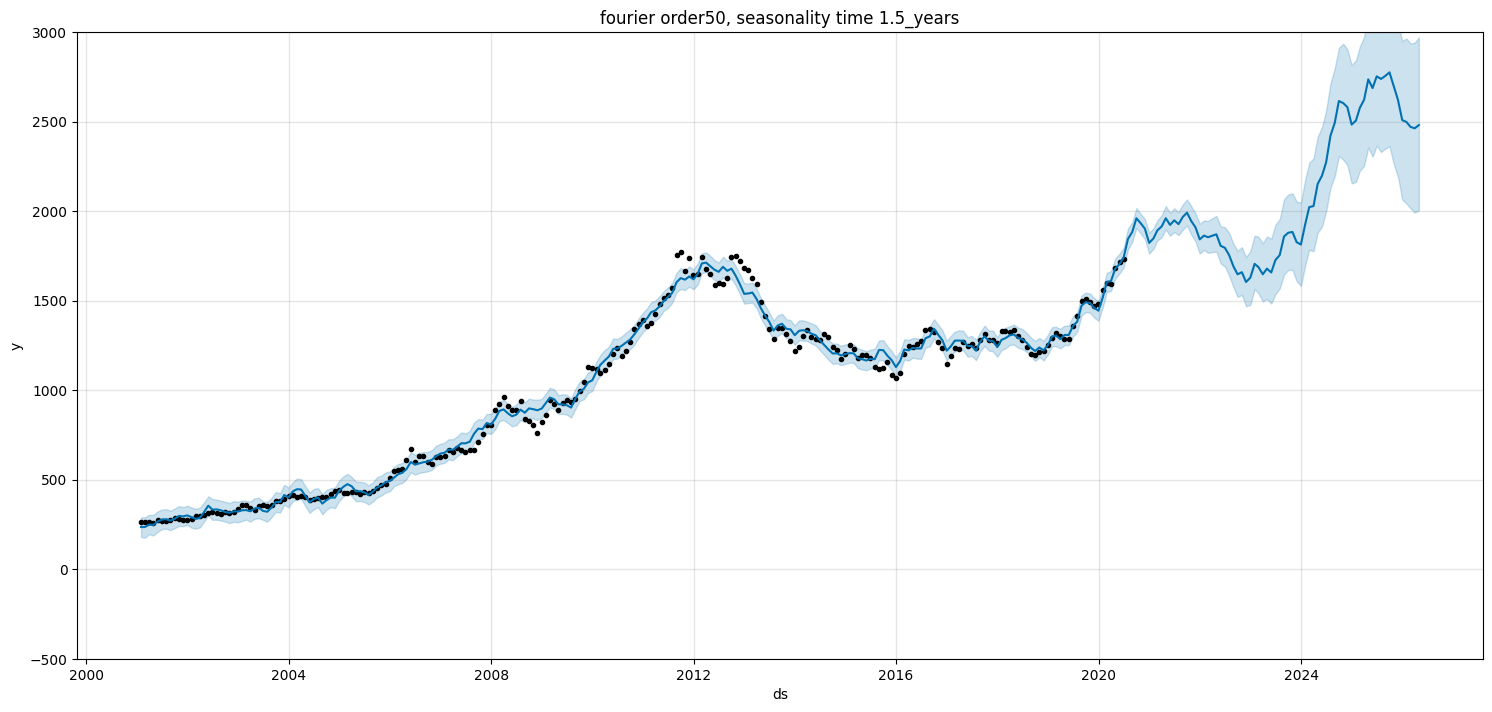

Total Execution Time 1.084376573562622 seconds


In [48]:
training_set = df[:-48]
validation_set = df[-48:] #last 48 rows, i.e from Jul 2018
# 15 years seasonlaity, additive, no other seasonality, less fourier value
fifteen_years = fb_prophet_function(data=training_set, future_years=70, seasonality_name='1.5_years', seasonality_val=4*365, seasonality_fourier=50,seasonality_mode='additive')

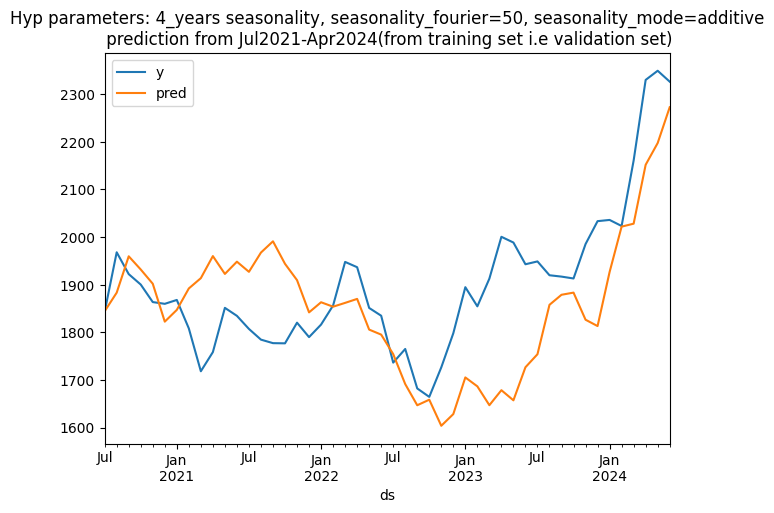

In [55]:
plot_valid(validation_set, 48, fifteen_years)
plt.title("Hyp parameters: 4_years seasonality, seasonality_fourier=50, seasonality_mode=additive\n prediction from Jul2021-Apr2024(from training set i.e validation set)");

In [59]:
# prompt: give me the code for calculating RMSE for above 15_year model

import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate the RMSE for the 15_year model
rmse_4_year = np.sqrt(mean_squared_error(validation_set['y'], fifteen_years.predict(validation_set)['yhat']))

print(f"RMSE for 4_year model: {rmse_4_year:.2f}")


RMSE for 4_year model: 138.27


In [57]:
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(validation_set['y'], fifteen_years.predict(validation_set)['yhat'])
mae

109.97043485395098

In [58]:
from sklearn.metrics import mean_absolute_percentage_error
# y_pred = final_tes_model.forecast(48)
mape = mean_absolute_percentage_error(validation_set['y'], fifteen_years.predict(validation_set)['yhat'])
print(mape)

0.057637345242584535


Saving model in pickle format for further deployment

In [53]:
import pickle

In [54]:
# prompt: i want to save my model 15 years as pickle file in google drive in this folder /content/drive/MyDrive/model pickle

import pickle

# Save the model to a pickle file
with open('/content/drive/MyDrive/model pickle/prophet_model_4_years_custom_seasonality.pkl', 'wb') as f:
    pickle.dump(fifteen_years, f)